<header style="text-align:center;color:darkgray">Introduction to Next Generation Sequencing</header>
<header style="text-align:center;color:darkgray">2022</header>

# Section 10: DGE Analysis in R

<p><b>Don't forget you can drag the borders of the bottom section to enlarge it. You will not be using the terminal for this section.</b></p>

Previously you aligned RNA-Seq reads from the Krizek et. al 2020 dataset (8 hour control) to the Arabidopsis genome. You can find the output of this alignment in the <span style="font-family:monospace;color:#1F45FC;background-color:#EBF4FA;font-weight:bold;padding:3px;">8hr_control_1</span> directory, as well as the Salmon output files for another five samples: two 8 hour control samples and three 8 hour treated samples. You will be importing the read count data (the number of reads that mapped to each gene) from the Salmon output files, using the R package <a href="https://bioconductor.org/packages/release/bioc/html/tximport.html">tximport</a>. You will identify differentially expressed genes using <a href="https://bioconductor.org/packages/release/bioc/html/DESeq2.html">DESeq2</a>  and calculate Gene Ontology (GO) enrichment using <a href="https://bioconductor.org/packages/release/bioc/html/goseq.html">goseq</a>.

It should be noted that these are not the packages that were used by were used by Krizek et. al 2020. They used <code>TopHat</code>/<code>Bowtie2</code> for alignment, <code>edgeR</code> for DGE analysis and <code>AMIGO</code> for GO enrichment. However, each of the tools used here also have widespread use in the bioinformatics community. 

**Important reminder: Check that your Kernel is active at the top right of the notebook. The kernel will stop after a period of inactivity; this  will cause all stored variables (R objects) and loaded packages to disappear (and code cells will stop executing or producing output). You can quickly restore the environment by activating the kernel and selecting the last cell you were on, then going to the "Run" menu and selecting "Run All Above Selected Cell" - this will rerun all of the code cells you have already done.**

<img src="./public/run_above.png">

The steps of this general DGE analysis pipeline are given below:

1. [Import the Salmon count data using tximport](#Import-Salmon-counts:-tximport)
2. [Import data into DESeq2](#Import-data-in-DESeq2)
3. [Quality Control of the count data](#Quality-checking:-Principal-Component-Analysis)
4. [Run DGE analysis using DESeq2](#Differential-Expression-Testing)
5. [Investigate the DGE results]()
6. [Perform GO enrichment analysis]()

The very first step will be to enable R execution in the notebook, and then to load all of the packages you will be using in this session using the `library()` function:

In [ ]:
# enable execution of R code
%load_ext rpy2.ipython

In addition, it will be necessary to navigate to the <span class="path">day5_exercises</span> folder - however, this must be done from the notebook. You can use the `%cd` Python command to change directories and the `%ls` command to view the directory contents (not that this is a Python cell, not an R cell):

In [ ]:
# navigate to the day5_exercises directory
%cd day5_exercises
# view directory contents
%ls

In [ ]:
%%R
# load the required R packages
library(tximport)
library(readr) # required by tximport
library(DESeq2)
library(ggplot2) # used for some plotting
library(pheatmap) # used fo rheatmaps
library(goseq)


# to hide the output of this cell, click the blue bar to the left of the output box

Finally, you will need to recreate three of the R objects you made yesterday: `quantfiles`, `tx2gene` and the `sample_table` dataframe.

### _quantfiles_

The `quantfiles` object is a _list of paths_ to the Salmon count files (<span class="path">quant.sf</span>):

```R
# paths to the Salmon output files
8hr_control_1/quant.sf
8hr_control_2/quant.sf
8hr_control_3/quant.sf
8hr_treated_1/quant.sf
8hr_treated_2/quant.sf
8hr_treated_3/quant.sf
```

<div style="align-text: center;margin-top: 0px;margin-bottom: 0px;">
<details style="background-color:black;width:calc(100% - 40px);margin-left:auto;margin-right:auto;margin-top:10px;margin-bottom:10px;">
<summary style="background-color:cornflowerblue;padding: 10px;outline: none;">Recreate the <code>quantfiles</code> list using R in the cell below and check that each file exists</summary>
<div style="background-color:skyblue;padding:10px;">
	<p class="answer">
		<code>sample_types=c("control","treated")</code><br>
		<code>rep_number=c("1","2","3")</code><br>
		<code>quantfiles=paste0("8hr_",rep(sample_types,each=3),"_",rep(rep_number,times=2),"/quant.sf")</code><br>
		<code>print(file.exists(quantfiles))</code>
	</p>
</div>
</details>
</div>

In [ ]:
%%R
# quantfiles object

### _tx2gene_

The `tx2gene` object is simply the list of transcript/gene IDs you created yesterday. A copy of the file you made is in the current directory.

<div style="align-text: center;margin-top: 0px;margin-bottom: 0px;">
<details style="background-color:black;width:calc(100% - 40px);margin-left:auto;margin-right:auto;margin-top:10px;margin-bottom:10px;">
<summary style="background-color:cornflowerblue;padding: 10px;outline: none;">Import the data from the <span class="path">transcript-to-gene.txt</span> file into R and view the top 10 lines</summary>
<div style="background-color:skyblue;padding:10px;">
	<p class="answer">
	<code>tx2gene=read.table("transcript-to-gene.txt",header=TRUE)</code><br>
	<code>head(tx2gene)</code><br>
	</p>
</div>
</details>
</div>

In [ ]:
%%R
# import tx2gene data

### _sample_table_

The `sample_table` dataframe contains the sample information for the experiment:

```R
         sample condition
1 8hr_treated_1   treated
2 8hr_treated_2   treated
3 8hr_treated_3   treated
4 8hr_control_1   control
5 8hr_control_2   control
6 8hr_control_3   control
```

<div style="align-text: center;margin-top: 0px;margin-bottom: 0px;">
<details style="background-color:black;width:calc(100% - 40px);margin-left:auto;margin-right:auto;margin-top:10px;margin-bottom:10px;">
<summary style="background-color:cornflowerblue;padding: 10px;outline: none;">Create the <code>sample_table</code> dataframe</summary>
<div style="background-color:skyblue;padding:10px;">
	<p class="answer">
	<code>samples=paste0("8hr_",rep(c("treated","control"),each=3),rep(c("_1","_2","_3"),times=2))</code><br>
	<code>conditions=rep(c("treated","control"),each=3)</code><br>
	<code>sample_table=do.call(rbind,Map(data.frame,sample=factor(samples),condition=factor(conditions)))</code><br>
	<code>sample_table</code>
	</p>
</div>
</details>
</div>

In [ ]:
%%R
# create the sample table

## Import Salmon counts: `tximport`

You are now ready to run your DGE analysis:

1. [Import the Salmon count data using tximport](#Import-Salmon-counts:-tximport)
2. [Import data into DESeq2](#Import-data-in-DESeq2)
3. [Quality Control of the count data](#Quality-checking:-Principal-Component-Analysis)
4. [Run DGE analysis using DESeq2](#Differential-Expression-Testing)
5. [Investigate the DGE results]()
6. [Perform GO enrichment analysis]()

The <a href="https://bioconductor.org/packages/release/bioc/html/tximport.html">tximport</a> tool was created by the same group that made <a href="https://bioconductor.org/packages/release/bioc/html/DESeq2.html">DESeq2</a>. Its purpose is to import count data into DESeq2 in a quick and simple fashion, such as that produced by Salmon. It can also summarise _transcript-level_ counts to _gene-level_ counts (as discussed yesterday).

The `tximport` command requires three important arguments:

```R
tximport([path to count files],type="[aligner]",tx2gene=[transcript-to-gene mapping])
```

You can check the help file for tximport by running `?tximport` in R. This will work for any other R commands, similar to `[command] --help` in Bash.

Obviously, the mapping was performed by Salmon so the `type=` argument should be "salmon". You have already prepared the count files and transcript-to-gene mappings above (`quantfiles` and `tx2gene`, respectively). The per-transcript counts will be used to generate _per-gene_ counts by `tximport`, so that DESeq2 will calculate differential expression based on gene counts.

Import the count data using DESeq2:

In [ ]:
%%R
# import count data; this should take a few seconds and will print some output
txi=tximport(quantfiles,type="salmon",tx2gene=tx2gene)

## Import data in DESeq2

<a href="https://bioconductor.org/packages/release/bioc/html/DESeq2.html">DESeq2</a> is a statistical package used to test for differential gene expression based on high-throughput read count data. The <a href="https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html">documentation</a> and <a href="https://doi.org/10.1186/s13059-014-0550-8">original paper</a> provide excellent insight into DGE analysis and the methods used by the software, and the authors have also created several incredibly useful <a href="https://bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html">example workflows</a> for RNA-Seq analysis.

The function `DESeqDataSetFromTximport()` can be used to create a DESeq2 "data object" (containing all the necessary information to run a statistical analysis) directly from the `tximport` output:

```R
DESeqDataSetFromTximport([tximport data],colData=[sample table],design=[design])
```

This function takes three arguments: the first is the `tximport` data (i.e. the `txi` object you created above); the second is a sample table supplied to `colData=` (i.e. the `sample_table` dataframe you create previously), and lastly it requires a `design=` argument, which will be a "design formula" .

The complexity of the design argument is too great to discuss in detail in this workshop, but the design formula is used when creating the sample model. This experiment consists of a very simple design, which can be observed by viewing the `sample_table` dataframe:

In [ ]:
%%R
# view the sample_table object (executing just the variable will print it - be careful if it is very long!)
sample_table

<br>

The only variable that is being modeled in these samples is the effect of the "condition" column - i.e. the effect of treatment compared to control. Thus, the data is being _modeled as a function of "condition"_ (the values in the condition column). The way to express this concept - "modeled as a function of" - in factorial models is the tilde (~) symbol, so the design for this experiment is simply:

```R
# model is a function of condition
design=~condition
```

A more complex design might account for one or more effects, such as the effect of treatment on samples at different time points. Compare the following sample table:

```R
          sample time condition
1  2hr_treated_1    2   treated
2  2hr_treated_2    2   treated
3  2hr_treated_3    2   treated
4  2hr_control_1    2   control
5  2hr_control_2    2   control
6  2hr_control_3    2   control
7  4hr_treated_1    4   treated
8  4hr_treated_2    4   treated
9  4hr_treated_3    4   treated
10 4hr_control_1    4   control
11 4hr_control_2    4   control
12 4hr_control_3    4   control
13 8hr_treated_1    8   treated
14 8hr_treated_2    8   treated
15 8hr_treated_3    8   treated
16 8hr_control_1    8   control
17 8hr_control_2    8   control
18 8hr_control_3    8   control
```

This dataset (modelled after the full Krizek et al. study) contains three time points (2, 4 and 8 hours), with a treated and control at each point. One way to construct a model for these samples would be "test for the effect of condition, controlling for the effect of time" - i.e. ignore the effects that appear _only_ because of time (clock genes, general shifts in gene expression unrelated to treatment) and _then_ measure changes due to treatment after controlling for these factors. A design to do this would be:

```R
# model as a function of condition, controlling for time
design=~time+condition
```

DESeq2 can account for _far_ more complex models that include the effects of genotype, paired samples, batch effects, gender and more (simultaneously). An example is given <a href="https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#interactions">in the DESeq2 manual</a> if you would like to investigate a slightly more complex interaction in detail.

In summary, the following command will create the DESeq2 data object `dds`:

In [ ]:
%%R
# use txi and sample_table objects, and specify design
# save object as "dds" - a DESeq dataset
dds=DESeqDataSetFromTximport(txi,colData=sample_table,design=~condition)

Each row in the `dds` object corresponds to a gene. You can use the `nrow()` (number of rows) function to calculate how many rows are in an object:

In [ ]:
%%R
nrow(dds)

This dataset contains 33027 genes. However, many of those genes do not have any mapped reads - i.e. the total count across all samples is 0. They are adding nothing to the analysis, so they can safely be removed from the dataset. The code cell below will remove all genes without at least one mapped read from the `dds` object:

In [ ]:
%%R
# prefilter dataset to keep genes with at least one mapped read (this could be more stringent, but is unnecessary)
keep=rowSums(counts(dds)) > 1 # find a list of the rows where the number of mapped reads is at least 1
dds=dds[keep,] # subset the dds object using the list of rows found above
nrow(dds) # see how many genes remain

Prefiltering has removed nearly 10,000 genes from the analysis that would do nothing but slow the process and increase the size of the output files.

### _Levels_

In R, factors have "levels", which represent the distinct categories the underlying data can have (i.e. categorical variables). The "condition" column, despite having six values, has two levels: "treated" and "control", since all values belong to one of these categories. 

<div style="align-text: center;margin-top: 0px;margin-bottom: 0px;">
<details style="background-color:black;width:calc(100% - 40px);margin-left:auto;margin-right:auto;margin-top:10px;margin-bottom:10px;">
<summary style="background-color:cornflowerblue;padding: 10px;outline: none;">View the "condition" column of the <code>dds</code> object (dataframe)</summary>
<div style="background-color:skyblue;padding:10px;">
	<p class="answer">
	<code>dds&dollar;condition</code><br><br>
	<span>You can use any of the methods used to extract column data from a dataframe that were discussed yesterday.</span>
	</p>
</div>
</details>
</div>

In [ ]:
%%R
# view condition column of the dds object

The order of the levels is usually alphabetical, as you can see in the output of the above cell (control followed by treated):

```R
[1] treated treated treated control control control
Levels: control treated
```

DESeq2 uses factor levels when giving the default statistical comparisons: all levels will be compared to the first level, which should normally be set to the "reference" level (control). This can catch out those unfamiliar with R and DESeq2, so it is something to be aware of (though it is not relevant to this particular analysis).

If the default levels are not correct, they can be edited using the R `relevel()` function:

```bash
# for example, to set the reference to treatment instead
# this would directly edit the original dds object
dds$condition=relevel(dds$condition,ref="treatment")
[1] treated treated treated control control control
Levels: treated control
```

If you continued the analysis using the releved `dds` object above, the expected output would be swapped: genes reported as up-regulated would be those with increased expression in the _control_ versus the reference (treatment), rather than those up-regulated due to treatment. However, levels do not influence the statistical analysis; you could simply swap the signs of all results and it would be correct. This also only effects the default output - you can specify sample vs. sample contrasts when extracting the output (this will be explained later). 

## Quality checking: Principal Component Analysis

Before continuing the DGE analysis it can be a good idea to get a general overview of the data. Principal component analysis (PCA) is a good way to see the trend of the data and samples quickly, allowing you to verify that there are no obvious batch effects or outlier samples.

To run PCA on the count data we need it to be normalised in some way. This could be done using a log2 transformation, but this would not account for library size or the effect of genes with very small read counts (which will have high variance when measured on the log scale). DESeq2 contains <a href="https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#how-do-i-use-vst-or-rlog-data-for-differential-testing">two normalisation functions</a> that can be used instead of a simple log2 normalisation: `vst()` (_variance stabilising transformation_) and `rlog()` (_regularised logarithm_).

Create a new object, `rdds`, by running `rlog()` on the DESeq2 data object (`dds`). Add the argument `blind=TRUE` so that the function will not try to correct the data based on the conditions - we want it to be entirely unbiased:

In [ ]:
%%R
# run regularised log
# use blind=TRUE to ignore the model design
rdds=rlog(dds,blind=TRUE)

<br>

The `rlog` data is useful for comparison or clustering of samples for the purposes of visualisation, but should never be used for statistical analysis. For PCA you will want to use `blind=TRUE`, since we are interested in independently assessing the difference between samples. For clustering or visualisation you would rerun this step using `blind=FALSE`, so that the normalisation will incorporate the expected differences between the samples.

DESeq2 includes a method for plotting a PCA using count data, `plotPCA()`. By default it will calculate the components using the top 500 genes that display the largest variance, but this can be adjusted using the `ntop=` argument. It does not add the sample names by default but these can be included using the R plotting package `ggplot2`:

In [ ]:
%%R
# plot the rdds data as a PCA plot
# use geom_text to add the sample names (rdds$sample) to each point (you can read the gpplot2 documentation for more details)
plotPCA(rdds,ntop=500)+geom_text(aes(label=rdds$sample),vjust="inward",hjust="inward",size=4)

The PCA plot shows that the first principal component - i.e. the component that encompasses the largest proportion of variation - has a value of 36%. Unsurprisingly this component appears to separate the control and treatment samples, suggesting that the majority of variation is due to gene expression changes caused by ANT-GR activation. The 2nd component accounts for only 26% of the variation, thus other higher-order components must account for the balance (~38%) of the sample variation. PC2 separates the biological replicates, suggesting that there is a non-negligible amount of biological variation between the samples, particularly the `8_treated_1` and `8hr_control_3` samples.

There is little that can be done to correct underlying variation in a dataset, since in most cases it simply represents actual biological variation in the sampled tissues. In some cases these differences may be due to "batch effects" (e.g. all samples on one day show a trend that is not visible in other samples); these can be controlled using statistical packages or even by including `batch` as a factor in the experimental design:

```R
# model condition, correcting for batch effects
design=~batch+condition
```

The variation in this dataset will effect the statistical power to detect differentially expressed (DE) genes (since there will be uncertainty as to whether they are DE or merely genes with high variance), but ultimately will not impact how we run the analysis today.

## Differential Expression Testing

DESeq2 will use the `dds` dataset (not the rlog `rdds` dataset) to fit the design model and run statistical testing over all samples. This is done using the `DESeq()` function, and supplying the `dds` object as an argument.

The `DESeq()` function is actually running five distinct steps:

1. **Estimate size factors**: Calculate the values that will be used to normalise reads to library size. This prevents sample bias caused by some samples being sequenced with greater depth (more reads) than other samples.
2. **Estimate gene-wise dispersions**: Calculate the dispersion for each gene - essentially the variance controlling for the mean read count. Genes with similar counts are assumed to have a similar dispersion.
3. **Mean-dispersion relationship**: Calculate the average dispersion across all genes - this will be used as the baseline to test differential expression
4. **Final dispersion estimates**: For genes with large dispersion, shirnk them towards the baseline so that they are less likely to be tested as DE
5. **Fitting model for each gene**: Test each gene against the dispersion estimates calculated above

Run the `DESeq()` test in the cell below:

In [ ]:
%%R
# this will take ~30 seconds to run
# the command will print out the step of the analysis that it is on; ending on "fitting mode and testing"
# write output to dds_test
dds_test=DESeq(dds)

### Comparisons and contrasts

The `DESeq()` function will perform modelling and testing for the design specified in the original import step (i.e. `design=~condition`). Depending on the design, you would expect a different set of tested comparisons. For the design of this experiment you would expect only a single comparison, `treated` versus `control`, since these were the only two levels in the condition.

If the experiment had included two different treatments in the condition column:

```R
# example with two treatments
         sample condition
1  2hr_control_1    control
2  2hr_control_2    control
3  2hr_control_3    control
4 2hr_treatedA_1   treatedA
5 2hr_treatedA_2   treatedA
6 2hr_treatedA_3   treatedA
7 2hr_treatedB_1   treatedB
8 2hr_treatedB_2   treatedB
9 2hr_treatedB_3   treatedB
```

Then you would expect there to be more comparisons - `treatedA` versus `control`, `treatedB` versus `control` and `treatedB` versus `treatedA`.

You can view the different tests that were performed using the `resultsNames()` function on the results of the `DESeq()` command:

In [ ]:
%%R
# Intercept is essentially the regression line passing through all samples, against which expression is compared
resultsNames(dds_test)

<br>

This analysis only has a single contrast, `condition_treated_vs_control`, corresponding (obviously) to the comparison between treated and control samples. If there were additional conditions, or other factors in the design, then there would be additional names.

## The `results()` function

You can access the results of a specific test using the DESeq2 `results()` function. To get the results for a specific comparison simply supply the name of that comparison (as obtained using `resultsNames()`) to the `name=` argument of `results()`:

```R
results(dds_test,name="condition_treated_vs_control",alpha=0.05)
```

Alternatively, also using the `results()` command, you can get the results of a specific pair of "contrasts" from a particular design factor using the `contrast()` argument and a list `c(factor,treatment,reference)`:

```R
# find the results for the comparison "treatment" versus reference "control" from the column "condition"
results(dds_test,contrast=c("condition","treated","control"),alpha=0.05)

# assuming you were also testing Time:
# find the results for the comparison "8h" versus reference "2h" from the column "time"
results(dds_test,contrast=c("time","8h","2hr"),alpha=0.05)
```

### False Discovery Rate

The `alpha=` argument specifies the False Discovery Rate (FDR) that will be used as a significance threshold. This value corresponds to the adjusted p-value after correcting for multiple testing. The DESeq2 authors recommend a FDR cutoff of 0.1, but researchers will often opt for a more strict cut-off, such as 0.05 or 0.01. The study from which this data derived used a cut-off of 0.05.




You can calculate the DGE analysis results for the 8 hour Krizek et al. samples by using either of these methods (simply change the code in the R cell), then use `head()` to view the top of the results object:

In [ ]:
%%R
# write results to the "res" object
res=results(dds_test,name="condition_treated_vs_control",alpha=0.05)

# view the top of the object
head(res)

### Results output

The output of the `results()` function is a dataframe where each row is a gene. There are six columns containing information about the expression of each gene:


- _baseMean_: the average _normalised_ expression of a gene across all replicates
- _log2FoldChange_: the fold change estimate of the expression in "treated" relative to "control" samples (depending on contrast)
- _lfcSE_: the standard error of the fold change estimate
- _stat_: the Wald statistic used to generate the p-value
- _pvalue_: the p-value prior to multiple testing
- _padj_: the adjusted p-value (FDR)

Wrapping the entire `results()` command (or the `res` object) in the DESeq2 `summary()` function will produce a summary of the results: 

In [ ]:
%%R
# Obtain a summary of the results
summary(res)

From this summary you can see that:

1. 25525 genes had reads assigned to them,
2. the FDR cut-off is 0.05,
3. 99 genes were up-regulated (0.39% of all genes) (LFC > 0),
4. 147 genes were down-regulated (0.58% of all genes) (LFC < 0),
5. 1 gene was an outlier (too variable to consider DE - its p-value will be NA),
6. 3464 genes (14%) had counts so low (<4) that they were dropped from the analysis so as not to disrupt multiple testing (p-value set to NA)

Try to relax the FDR value in the cell below and see how this changes the number of DE genes depending on the value you set it to.

In [ ]:
%%R
# Decreasing FDR will reduce the number of DE genes; increasing it will do the opposite
summary(results(dds_test,name="condition_treated_vs_control",alpha=0.1))

### Visualising DGE Results

You can use an MA plot to quickly view the DE genes compared to non-DE genes. An MA plot shows the log2 fold-change (LFC) of all genes (on the y-axis) compared to the mean count (on the x-axis), with non-DE genes in grey and DE genes in red.

Create an MA plot using the `plotMA()` function, supplying the results `res` object:

In [ ]:
%%R
# the higher the normalised count, the lower the LFC required for a gene to be tested as DE
plotMA(res)

As you might expect, genes with low mean counts require more evidence (larger LFC) to be confidently called DE, whereas genes with higher counts would be expected to have a more restrained variance. This is directly visible by the relative proximity of DE genes to the central red line representing a LFC of 0 - genes with higher counts are far more likely to be DE and have a small LFC.

The "flaring" of the LFC values at very low read counts on this plot is the reason why the `rlog()` and `vst()` normalisations should be used when checking the data - the raw log2FC values will be extremely volatile in genes with low counts compared to high counts.

### Fold Change Cutoffs

Something to take away from the MA plot is that in this test, the FDR is the measure of whether a gene's expression is significantly different from the null, which is LFC=0. Often, researchers will further restrict the definition of DE genes in their study by a LFC cut-off. For example, by stating that only genes that have both a FDR < 0.05 and a LFC > 1 were used in downstream analyses. Though this is very common, it technically strips the meaning from the final set of FDR values which were calculated assuming a difference from LFC=0.

A better way of doing this is to use the DESeq2 `altHypothesis=` and `lfcThreshold=` arguments to `results()`, which can be used to test whether gene expression is significantly different to an arbitrary LFC threshold:

```R
results(dds_test,name="condition_treated_vs_control",alpha=0.05,lfcThreshold=[LFC],altHypothesis=["test"])
```

The `lfcThreshold=` argument is simply the LFC to use as a cutoff - such as 0.5 or 1 (LFC = 1 is equivalent to a doubling of expression, LFC = -1 is requivalent to halving).

The `altHypothesis=` is used to define how your genes are tested against the LFC threshold:

1. "greaterAbs": absolute value of gene LFC is greater than the LFC threshold (|LFC| > threshold) _- top left_
2. "lessAbs": absolute value of gene LFC is less than the LFC threshold (|LFC| < threshold) _- top right_
3. "greater": gene LFC is greater than +LFC threshold _- bottom left_
4. "less": gene LFC is less than -LFC treshold _- bottom right_

You can compare the difference in the image below, from the DESeq2 documentation:

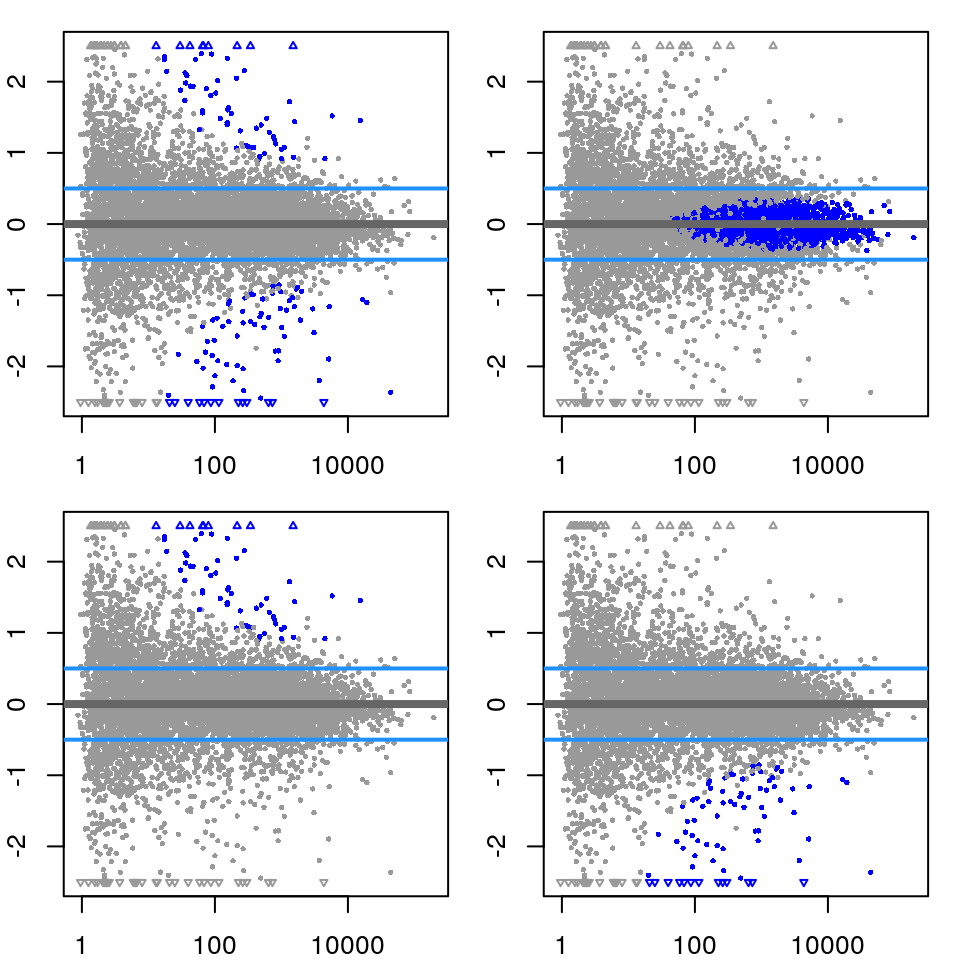

<br>

Notice that in the above examples a gene that is close to the LFC threshold is unlikely to be classified as DE, in much the same way that genes near the LFC=0 line were unlikely to be DE in your MA plot. However, if you were simply using a LFC cut-off, every DE gene at or above this line would have been included in the final set.

In the MA-plot you created it is obvious that not many DE genes show a large change in expression, since most DE genes are firmly within the |LFC| > 1 range (ie. their expression is rarely even double or half that of the control sample).

<div style="align-text: center;margin-top: 0px;margin-bottom: 0px;">
<details style="background-color:black;width:calc(100% - 40px);margin-left:auto;margin-right:auto;margin-top:10px;margin-bottom:10px;">
<summary style="background-color:cornflowerblue;padding: 10px;outline: none;">Using the information above, re-run the <code>results()</code> function using an alternate LFC threshold of 1 and the "greaterAbs" test. How many genes are DE?</summary>
<div style="background-color:skyblue;padding:10px;">
	<p class="answer">
	<code>res_alt=results(dds_test,name="condition_treated_vs_control",alpha=0.05,lfcThreshold=1,altHypothesis="greaterAbs")</code><br>
	<code>summary(res_alt)</code><br>
	<code>plotMA(res_alt)</code><br>
	</p>
</div>
</details>
</div>

In [ ]:
%%R
# rerun the results() test using a lfcThreshold of 1 and altHypothesis of "greaterAbs"

By restricting the LFC threshold to include only genes that have expression that is at least significantly different to |LFC|>1 (i.e. either higher than double or less than half the control expression), the number of DE genes drops to zero. This suggests that, though there are over a hundred genes with _significant_ changes between the treated and control samples (expression changes that are statistically unlikely to be due to chance), the _effect size_ of these changes is comparatively small.

Whether this is a concern is not easily decided. The effect of any particular treatment may be subtle and many genes (particularly transcription factors) may require only small shifts in transcript levels to result in significantly altered downstream pathways. The authors of the Krizek et al. 2020 paper did not use a LFC cut-off for their analysis, so the remainder of this analysis will be performed on the unfiltered dataset.

### Shrinking LFC

As is clear from the MA plots above, the inflation of the LFC of low-count genes could be problematic if we wanted to use these values to rank or visualise the genes, since genes with low counts would dominate the extremes of this list. DESeq2 includes another function, `lfcShrink()`, which can be used to <a href="https://bioconductor.org/packages/release/bioc/vignettes/apeglm/inst/doc/apeglm.html">shrink the effect size</a> (LFC) of genes. This step is performed independent of statistical testing - it will not alter any of the FDR values, or presence or number of DE genes - but merely serves to reduce the size of the estimated fold changes for each gene.

The `lfcShrink()` argument takes four standard arguments:

```R
res = lfcShrink([deseq dataset],coef=[resultsname],type="apeglm",res=[results object])
```

It requires the DESeq2 dataset that contains the model and test results (defined in this analysis as `dds_test`), and the "coefficient" that will be shrunk - this would generally be the contrasts that you are comparing (e.g. treatment vs. control), and will be one of the values from the `resultsNames()` function. The method of performing shrinkage is given to the `type=` argument, but "apeglm" is the recommended option. Lastly, it can take an existing results object, in which case it will overwrite the values for the "_log2FoldChange_" and "_lfcSE_" columns with the new, shrunken LFC.

<div style="align-text: center;margin-top: 0px;margin-bottom: 0px;">
<details style="background-color:black;width:calc(100% - 40px);margin-left:auto;margin-right:auto;margin-top:10px;margin-bottom:10px;">
<summary style="background-color:cornflowerblue;padding: 10px;outline: none;">Run <code>lfcShrink</code> on the <code>res</code> object in the code cell below</summary>
<div style="background-color:skyblue;padding:10px;">
	<p class="answer">
	<code>res = lfcShrink(dds_test,coef="condition_treated_vs_control",type="apeglm",res=res)</code><br>
	</p>
</div>
</details>
</div>

<div style="align-text: center;margin-top: 0px;margin-bottom: 0px;">
<details style="background-color:black;width:calc(100% - 40px);margin-left:auto;margin-right:auto;margin-top:10px;margin-bottom:10px;">
<summary style="background-color:cornflowerblue;padding: 10px;outline: none;">Create a new MA plot for the shrunken results and include the argument <code>ylim=c(-1,1)</code> in the command</code></summary>
<div style="background-color:skyblue;padding:10px;">
	<p class="answer">
	<code>plotMA(res,ylim=c(-1,1))</code><br><br>
	<span>Including <code>ylim=c(-1,1)</code> will cause the y-axis of the plot to span -1 and +1.</span>
	</p>
</div>
</details>
</div>

In [ ]:
%%R
# lfcShrink: overwrite results object with new, shrunken results
# note: this commmand will take a minute or two to run; check the kernel indicator to see when it is finished

In [ ]:
%%R
# make a new MA plot, including the argument ylim=c(-1,1)

The effect size of genes with low counts has been _massively_ reduced, whereas genes with larger and less-variable LFCs have not been shrunk as much.

<div style="align-text: center;margin-top: 0px;margin-bottom: 0px;">
<details style="background-color:black;width:calc(100% - 40px);margin-left:auto;margin-right:auto;margin-top:10px;margin-bottom:10px;">
<summary style="background-color:cornflowerblue;padding: 10px;outline: none;">More info: <code>lfcShrink</code></summary>
<div style="background-color:skyblue;padding:10px;">
		<span>Technically, if you test for significance using a non-zero <code>lfcThreshold</code> and then run <code>lfcShrink</code>, it is possible to end up with some DE genes that then fall below the tested LFC threshold due to the LFC shrinkage. In this case it is important to remember that <code>lfcShrink</code> is not a statistical test, and that despite the shrunken LFCs these genes have still been determined to be significantly different from the given threshold by DESeq2.</span><br><br>
	<span>Since its release, DESeq2 has incorporated a second DGE test that uses <code>lfcThreshold</code> directly in the <code>lfcShrink</code> function, which calculates DGE in a slightly different way and, rather than producing an FDR, produces <i>s-values</i>. This function will not be explained in the workshop, but anyone interested in running DESeq2 and <code>lfcThreshold</code> should check the DESeq2 documentation for further information.</span><br>
</div>
</details>
</div>

## Heatmap

If you want to compare and cluster DE genes with similar expression patterns a heatmap is a good option. For heatmaps and clustering you will want to use the variance-stabilised normalised count data produced by either `vst()` or `rlog()`. Since you used regularised log when constructing the PCA plots, you can use it here as well. However, this time you must use the `blind=FALSE` argument so that the normalisation accounts for the differences you would expect to see between samples based on treatment: 

In [ ]:
%%R
rdds=rlog(dds,blind=FALSE)

You can now use the DE data and the regularised log data to create a heatmap.

This step requires a fair bit of R knowledge that has not been introduced, so the complete code is given here with only a brief explanation. The code will create a heatmap that clusters and compares the expression changes across all 246 DE genes and will print the heatmap image to the file <span class="path">heatmap.pdf</span>.

In [ ]:
%%R
# extract the names of all DE genes from the res object
sig=rownames(subset(res,padj<0.05))
# extract the rows corresponding to DE genes from the rlog data
rdds_de=assay(rdds)[sig,]
# center the rlog data by subtracting the row means
rdds_de=rdds_de-rowMeans(rdds_de)
# find the labels for the conditions
condition=as.data.frame(colData(rdds)[, c("condition")])
# create the heatmap
heatmap=pheatmap(rdds_de, annotation_col = condition)
# open an empty PDF file
pdf(file="heatmap.pdf",width=10,height=30)
# write the heatmap object to the PDF
heatmap

In [ ]:
%%R
# close the R plotting device after running the cell above
dev.off()

If you have not already done so, open the <span class="path">heatmap.pdf</span> file from the file browser. The heatmap separates the samples nicely into visible clusters of up-regulated (red) and down-regulated (blue) genes, and is consistent with there being significant differences between the control and treated samples.

## Saving the DESeq2 output

You can save files using the `write.csv()` function:

```R
write.csv(data,file="file.csv")
```

Simply provide the object to be saved as the data argument to the `write.csv()` function, and provide the desired filename to the `file=` argument. Sometimes you will need to convert the object to a format that is comptabile with csv, as done for some of the examples below. You can open the saved csv files from the JupyterLab file browser, if you want to view the contents.

### _rlog normalised counts_

You will want to save the rlog (or VST) normalised counts created by DESeq2 so that you can use them for visualisation or clustering (such as the heatmap, above). To extract the `rlog()` normalised count value matrix you can use the `assay()` function, supplying the `rdds` object as an argument. You can then save this data to a csv file using `write.csv()`:

In [ ]:
%%R
# write rlog to file
# for an actual analysis, you would want to include data and parameters in the file name
write.csv(assay(rdds),file="rdds.csv")

### _Results (DE genes, LFC)_

After the `lfcShrink()` step, the current results object (`res`) now contains the FDR values for each gene (and thus your list of DE and non-DE genes) as well as the _shrunken_ LFC values. You can simply save this object as a csv directly:

In [ ]:
%%R
# for an actual analysis, you would want to include data and parameters in the file name
write.csv(res,file="res.csv")

### _DESeq2 normalised counts_

The normalised counts produced by DESeq2 can be obtained from the `dds_test` object using the `counts()` function and the `normalized=TRUE` argument, and can be similarly saved directly to csv:

In [ ]:
%%R
# for an actual analysis, you would want to include data and parameters in the file name
write.csv(counts(dds_test,normalized=TRUE),file="norm_counts.csv")

# Functional GO Enrichment

You now have the primary results of the DGE analysis: a list of DE genes and their fold changes, and regularised log counts to perform clustering, heatmaps and PCA. You could check the list of DE genes to find any genes of interest, or analyse individual expression clusters.

However, one way to analyse the dataset as a whole is to is to perform Gene Ontology (GO) enrichment. <a href="https://en.wikipedia.org/wiki/Gene_ontology">Gene ontologies</a> are a way of representing gene functions using a controlled vocabulary shared across species. The GO terms can belong to one of three domains:

1. **Cellular component**: the parts of a cell or its extracellular (e.g. Cytoplasm, Nucleus) 
2. **Molecular function**: the activity of a gene at a molecular level, such binding or catalysis (e.g. Lactase Activity, RNA Binding)
3. **Biological process**: a defined process or pathway in which the gene operates (e.g. Photosynthesis, Stress Response)

Each GO term has a unique ID (such as GO:0009765) and a description (such as Photosynthesis).

GO enrichment is the process of comparing on or more _gene sets_ to see if those sets contain genes associated with certain GO terms at a rate higher (or lower) than would be expected by chance. For example, an RNA-Seq study that involved disrupting photosynthetic genes would expect that the proportion of DE genes related to photosynthesis and photosynthesis-related processes (i.e. containing GO terms related to the Biological Process of Photosynthesis) would be high - much higher than the proportion of photosynthesis genes amongst all genes in the genome. GO enrichment is usually calculated by comparing the present GO terms in an input gene set and a background gene set. In RNA-Seq, the input gene set would be the DE genes and the background gene set would be all _expressed_ genes (those present in the samples sequenced).

For this workshop you will be using the `goseq` <a href="https://bioconductor.org/packages/release/bioc/html/goseq.html">R package</a>. This package is specifically designed to be run downstream of RNA-Seq, as it can correct for the length bias that occurs in these datasets. Because longer genes are more likely to be sequenced, you would expect longer genes to occur more often in any list of DE genes. This disrupts the comparison between the input set and the background set, since the input set would always be slightly "enriched" for the GO terms associated with longer genes.

Running a GO enrichment using `goseq` pipeline will consist of several steps:

1. [Download a list of all GO terms and descriptions](#Download-all-GO-terms)
2. [Get a list of each GO term associated with each Arabidopsis gene](#Get-Arabidopsis-GO-data)
2. [Extract RNA-Seq gene length data from tximport](#Extract-DESeq2-gene-length-data)
3. [Create a list of DE and non-DE genes](#Create-a-list-of-DE-&-non-DE-genes)
4. [Goseq: Calculate length bias](#goseq:-Calculate-length-bias)
5. [Calculate GO enrichment](#Calculate-GO-Enrichment)

## Download all GO terms

A list of all GO terms can be found using the `GO.db` R package. You can access load this package using the `library()` function:

In [ ]:
%%R
library(GO.db)

You will need the GO terms to be in a dataframe consisting of a single column (the GO description) and with the GO ID as the row names. These can be extracted from the data available in the `GO.db` package:

In [ ]:
%%R
# extract the GO data from the GO.db package as a dataframe
goterms <- as.data.frame(unlist(Term(GOTERM)))
# set the dataframe column name to "GO_data"
colnames(goterms)=c("GO_name")
# view the top of the dataframe
head(goterms)

## Get Arabidopsis GO data

Most model species have been "annotated", which means that each of their genes has been associated with one or more GO terms dependent on the function of that gene. You can access the list of all Arabopsis GO data from <a href="https://www.arabidopsis.org/tools/bulk/go/index.jsp">www.arabidopsis.org</a>, although it will need to be converted into the correct format to work with `goseq`.

This file has been prepared for you and can be found in the <span class="path">day5_exercises</span> directory: <span class="path">ath.goterms.anno</span>.

<div style="align-text: center;margin-top: 0px;margin-bottom: 0px;">
<details style="background-color:black;width:calc(100% - 40px);margin-left:auto;margin-right:auto;margin-top:10px;margin-bottom:10px;">
<summary style="background-color:cornflowerblue;padding: 10px;outline: none;">Import the data from <span class="path">ath.goterms.anno</span> file into R as the object <code>ath_go</code></summary>
<div style="background-color:skyblue;padding:10px;">
	<p class="answer">
	<code>ath_go=read.table(file="ath.goterms.anno",header=FALSE,sep=",")</code><br>
	</p>
</div>
</details>
</div>

In [ ]:
%%R
# import the contents of the ath.goterms.anno file


In [ ]:
%%R
# convert the ath_go data object to a dataframe
ath_go=as.data.frame(ath_go)
# edit the column names of the ath_go object, and view the top of the file
colnames(ath_go)=c("Gene","GO")
head(ath_go)

## Extract DESeq2 gene length data

In order to correct the length bias in an RNA-Seq dataset, `goseq` requires the length of each gene in the dataset. Luckily, this can be easily obtained from the `dds_test` object:

In [ ]:
%%R
# use assay to get the dds_test data as a matrix, then extract the average transcript length ("avgTxLength")
lengths=rowMeans(assays(dds_test)[["avgTxLength"]])
# view the top of the file
head(lengths)

## Create a list of DE & non-DE genes

You will need a list of DE and non-DE genes which `goseq` can use to construct the input and background gene sets. This can be obtained from the `res` DESeq2 results object, by checking the adjusted p-value of each gene (i.e. FDR < 0.05). The result should be a named vector (similar to an associative array) where each gene name is associated with a value of either 0 or 1 depending on whether the gene is not-DE or DE, respectively.

Unfortunately, the method to do this is in R is a little convoluted:

In [ ]:
%%R
# if the padj value is NA set it to 1, else return padj
padj_nona=ifelse(is.na(res$padj),1,res$padj)
# create a list of 0 and 1 if a gene is DE or not DE
gene_list=as.integer(padj_nona <= 0.05)
# associate each of the 0/1 values to the gene name
names(gene_list)=rownames(res)
# view the top of this list
head(gene_list)

<br>

Given that the value for each printed gene is 0, the top few genes are all not DE. You can check the total number of DE and non-DE genes using the `table()` function, which will print the total number of 0 and 1 values in the list. There should be 246 "1" values, corresponding to the 246 DE genes:

In [ ]:
%%R
# view a table giving the number of DE and non-DE genes
table(gene_list)

## `goseq`: Calculate length bias

The first step of the `goseq` pipeline is to calculate the length bias (if any) that is present in the RNA-Seq data. This is done using the `nullp()` function, which uses the DE gene list and the gene lengths in the `lengths` object. Save these results as `pwf` - the `nullp()` function will automatically plot a graph showing the proportion of DE genes compared to gene length.

In [ ]:
%%R
pwf = nullp(gene_list, bias.data=lengths)

<br>

The x-axis of the plot above gives the average gene lengths, divided into 1000 bp bins. The y-axis is the proportion of genes that are DE. The bias in the longest genes is not as distinct in this dataset, but smaller genes (<1000 bp) are definitely less likely to be DE than longer genes. An example of a dataset with more obvious length bias is shown in the `goseq` documentation:

<img src="./public/length_bias.png" style="width:30%">

## Calculate GO Enrichment

Now that you know the length bias (`pwf`), you can calculate GO enrichment using the `goseq()` function. This command takes the `pwf` object and the list of Arabidopsis GO terms (`ath_go`). Using these it can construct the input and background gene sets and compare the lists of GO terms in each set, and the initial set of p-values associated with each enriched GO term.

After calculating the initial p-value it is necessary to do multiple correction to calculate an _adjusted_ p-value for each term using the `p.adjust()`:

In [ ]:
%%R
# calculate the GO enrichment
gores=goseq(pwf,gene2cat=ath_go)
# calculate the adjusted p-values
gores$padj=p.adjust(gores$over_represented_pvalue,method="BH")
# view the top of the results table
head(gores)

<br>

As a final step, we want to construct a results table that contains only GO terms that are significantly enriched using an adjusted p-value threshold of 0.05. In addition, it would be simpler to report only those GO terms that belong to the Biological Process (BP) domain: 

In [ ]:
%%R
# extract only significantly over-enriched BP GO terms from the results table (adjusted pvalue < 0.05)
goresBP=gores[gores$ontology == "BP" & gores$padj < 0.05,][,c("padj","term")]
# view the top 20 rows (although there are only 8)
head(goresBP,20)

## Conclusion

The Krizek et al. research paper found that GO terms related to floral development and hormone signalling - particularly auxin and jasmonic acid - were eniched in the ANT-GR samples treated with dexamethasone compared to the controls, consistent with the role of ANT as regulator of floral development.

The results of this exercise are surprisingly coherent with these results, especially considering that the dataset was only a small subset of the original data and that it was analysed using a completely different set of bioinformatic tools. Only eight GO terms were enriched in total, but included the "flower development" GO term as well as terms related to development in general, such as cotyledon vascular tissue formation and xyloglucan metabolic processes. In addition, terms related to both auxin (indoleacetic acid) and jasmonic acid appear in this list.

## Thank you!

This concludes the **NGS Analysis & Applications** course, created as part of the training activities of project <a href="https://resist.cpsbb.eu/index.html">RESIST</a> funded by the <a href="https://cordis.europa.eu/programme/id/H2020_MSCA-RISE-2018">European Union’s Horizon 2020 Research and Innovation Staff Exchange programme</a>. We hope you enjoyed it and that you found it useful and engaging.

The Binder servers for both courses should remain available after the end the workshop and are freely accessible at any time.

<hr>

Rafe Lyall<sup>1</sup> & Nicola Illing<sup>2</sup>

<sup>1</sup>_Department of Bioinformatics and Mathematical Modelling, Center of Plant Systems Biology and Biotechnology, Plovdiv, Bulgaria_<br>
<sup>2</sup>_Department of Molecular and Cell Biology, University of Cape Town, Rondebosch, South Africa_

<br>
<div>
<img src="./public/uct_logo.png" width="9%" style="vertical-align: middle">
<img src="./public/cpsbb_logo.png" width="12%" style="vertical-align: middle">
<img src="./public/resist_logo.png" width="12%" style="vertical-align: middle">
</div>

